### Partial Table of Contents

* [Data Analysis](#chapter1)
* * [Importing Data](#section_1_1)
* * [Dickey-Fuller Test](#section_1_2)
* [UFCNN-LSTM](#section_1_20)

In [1]:
import os
from keras.layers import LSTM, AlphaDropout, Dense, Activation
from keras.layers.convolutional import Convolution1D
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.backend import expand_dims
from tensorflow import keras, multiply, concat
from keras import layers, Input, Model, Sequential
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.layers import LSTM, Dense, BatchNormalization
import sklearn.metrics
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute, Lambda
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.layers import ConvLSTM2D, ConvLSTM1D
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT
import pywt
from tensorflow.python.keras.layers import Conv1D, GlobalAveragePooling2D
import random
from statsmodels.tsa.arima.model import ARIMA
tf.random.set_seed(1234)
np.random.seed(1234)
random.seed(1234)

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Data Analysis <a class="anchor" id="chapter1"></a>
#### Import Data <a class="anchor" id="section_1_1"></a>
We start by storing the electricity data in a pandas DataFrame

In [2]:
dfe = pd.read_csv("elec_14_22.csv",parse_dates = True, delimiter=',', header=0)
dfe['date'] = pd.to_datetime(dfe['date'], format='%Y-%m-%d')
dfe.index = dfe["date"]
del dfe['date']
dfe.head()

,code,e_price,p2,p3,p4,rand,code2
date,,,,,,,
2014-12-05,N4F15,47.20,47.20,47.20,47.20,10,385
2014-12-08,N4F15,46.56,46.56,46.51,46.56,20,525
2014-12-09,N4F15,46.64,46.64,46.64,46.64,0,485
2014-12-10,N4F15,46.53,46.53,46.53,46.53,0,485
2014-12-11,N4F15,46.05,46.05,45.98,45.98,10,475


#### Dickey-Fuller Test <a class="anchor" id="section_1_2"></a>
We create a function to perform the Dickey-Fuller test

In [158]:
def Dickey_Fuller_Test(df, target_name):
    """
    Perform Dickey-Fuller test on the input time series to check if it's stationary
    :df: a time series as a pandas dataframe
    :target_name: the column name of the column in the series which we are checking
    """
    print('Results of Dickey-Fuller Test for column ',target_name)
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items(): #print the critical values
        if key == '5%':
            dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05: #if the p-value is less than 0.05 we reject the null hypothesis
        print("Conclusion:")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print("series is non-stationary")

In [5]:
Dickey_Fuller_Test(dfe['e_price'], 'e_price')

Results of Dickey-Fuller Test for column  e_price
Test Statistic        -1.994168
p-value                0.289136
Critical Value (5%)   -2.863067
dtype: float64
Conclusion:
Fail to reject the null hypothesis
series is non-stationary


In [6]:
diff_data = dfe['e_price'].diff().dropna()
Dickey_Fuller_Test(diff_data, 'e_price')

Results of Dickey-Fuller Test for column  e_price
Test Statistic        -1.022676e+01
p-value                5.152786e-18
Critical Value (5%)   -2.863067e+00
dtype: float64
Conclusion:
Reject the null hypothesis
Data is stationary


Electricity futures price data plotted below

Text(0, 0.5, 'Electricity price £/MWh')

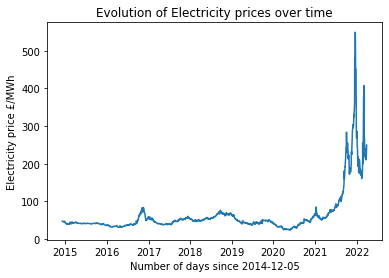

In [3]:
plt.plot(dfe['e_price'])
plt.title("Evolution of Electricity prices over time")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")

In [3]:
trainset_size = 1737
testset_size = len(dfe['e_price']) - trainset_size
print("Size of training set will be set to just before the price spike area of dataset: ",trainset_size)

Size of training set will be set to just before the price spike area of dataset:  1737


In [6]:
print("The size of the test set is ",testset_size)

The size of the test set is  150


The data is split into data to be used for training and data to be used for testing

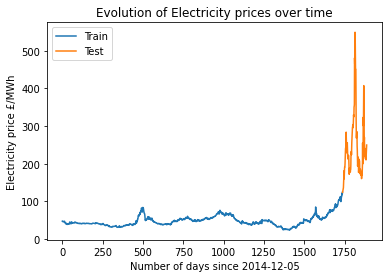

In [7]:
vals = dfe['e_price'].values

plt.plot(vals[:trainset_size], label="Train")
plt.plot(np.arange(trainset_size,len(dfe['e_price']),1),vals[trainset_size:], label="Test")
plt.title("Evolution of Electricity prices over time")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend()

#### PACF <a class="anchor" id="section_1_3"></a>
Get PACF of differenced electricity data

Text(0, 0.5, 'Change in Electricity Prices £/MWh')

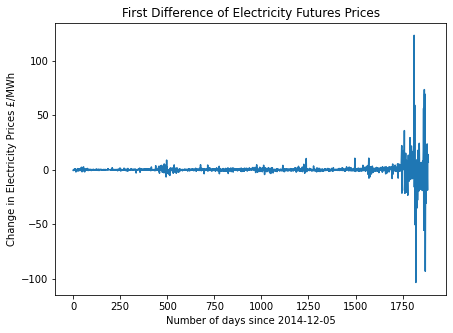

In [8]:
fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(7)
fig.set_figheight(5)
plt.plot(dfe['e_price'].diff().values)
plt.title("First Difference of Electricity Futures Prices")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Change in Electricity Prices £/MWh")

Apply partial autocorrelation function to electricity prices

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


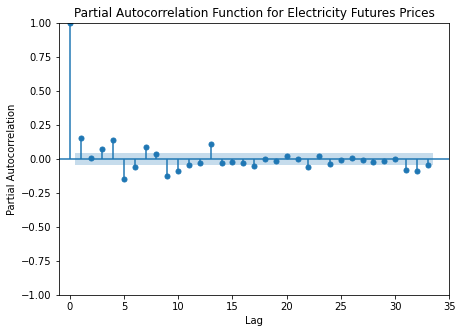

In [9]:
fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(7)
fig.set_figheight(5)

# axes[0].plot(dfe['e_price'].diff().values); axes[0].set_title('1st Differencing')
axes.set(ylim=(0,5))
axes.set(xlim=(-1,35))
plot_pacf(dfe['e_price'].diff().dropna().values, ax=axes)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.title("Partial Autocorrelation Function for Electricity Futures Prices")
plt.show()

#### ACF <a class="anchor" id="section_1_4"></a>
Apply autocorrelation to differenced electricity prices

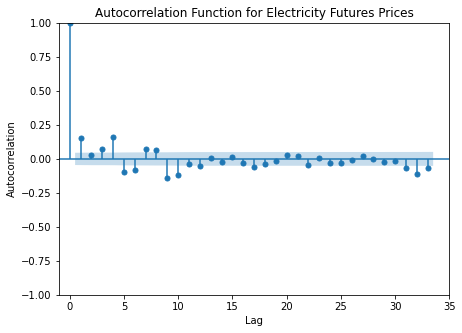

In [75]:
fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(7)
fig.set_figheight(5)

# axes[0].plot(dfe['e_price'].diff().values); axes[0].set_title('1st Differencing')
axes.set(ylim=(0,5))
axes.set(xlim=(-1,35))
plot_acf(dfe['e_price'].diff().dropna().values, ax=axes)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function for Electricity Futures Prices")
plt.show()

In [20]:
def calc_metrics(forecast,real=dfe['e_price'][-150:].values, printres=True):
    """
    Function calculates the metrics used in the analysis of the forecast of the models
    :param forecast: Forecast of the model
    :param real: Expected prices
    :return: tuple of length 4 of R-squared score, RMSE, MAE, MAPE
    """
    r2 = sklearn.metrics.r2_score(real, forecast)
    rmse = sklearn.metrics.mean_squared_error(real, forecast,squared=False)
    mae = sklearn.metrics.mean_absolute_error(real,forecast)
    mape = sklearn.metrics.mean_absolute_percentage_error(real, forecast)
    if printres:
        print("R-squared score is ", r2)
        print("RMSE is ", rmse)
        print("MAE is ", mae)
        print("MAPE score is ", mape)
    return r2, rmse, mae, mape

#### ARIMA <a class="anchor" id="section_1_3"></a>

Now the ARIMA(1,1,1) model is fitted and its prediction plotted

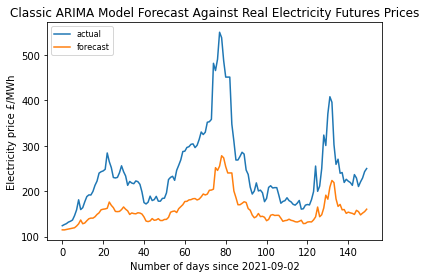

R-squared score is  -0.4074730176802217
RMSE is  98.08608859251095
MAE is  82.5798326272669
MAPE score is  0.3136573279078252


(-0.4074730176802217, 98.08608859251095, 82.5798326272669, 0.3136573279078252)

In [12]:
#define the testing set and training set
train = dfe['e_price'].values[:trainset_size]
test = dfe['e_price'].values[trainset_size:]

# 1,1,2 ARIMA Model
model = ARIMA(dfe['e_price'].values, order=(1,1,1))
fitted = model.fit()

pred_diff = dfe['e_price'][trainset_size-1:-1] - fitted.params[0] * dfe['e_price'][trainset_size-1:-1] -fitted.params[2]
fc = fitted.params[0] * dfe['e_price'][trainset_size-1:-1] + fitted.params[2] + fitted.params[1] * pred_diff

plt.plot(test, label='actual')
plt.plot(fc.values, label='forecast')

plt.title('Classic ARIMA Model Forecast Against Real Electricity Futures Prices')
plt.xlabel("Number of days since 2021-09-02")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(fc)

In [13]:
diff1 = dfe['e_price'].values[-150:] - dfe['e_price'].values[-151:-1]
diff2 = dfe['e_price'].values[-151:-1] - dfe['e_price'].values[-151:-1]
sklearn.metrics.r2_score(diff1,diff2)

-0.0011966861395704687

#### Refitted ARIMA <a class="anchor" id="section_1_3"></a>

In [14]:
def arima_preds(data,train_length,forecast_length,pred_length=5, order=(1,1,1)):
    """
    :param pred_length: The number of predictions to form
    :param order: the order of ARIMA model
    :param data: data used for model fitting
    :param train_length: number of data points used for fitting the model
    :param forecast_length: the number of data point to forecast
    :return: numpy array of forecasted data points with shape (forecast_length, pred_length)
    """
    forecast = np.zeros((forecast_length,pred_length))
    for i in range(forecast_length):
        model = ARIMA(data[i:train_length+i], order=order)
        fitted = model.fit()
        fc = fitted.forecast(pred_length, alpha=0.05)
        forecast[i, :] = fc[:]
    return forecast

In [186]:
import warnings
warnings.simplefilter('always', category=UserWarning)
window_sizes = np.arange(3,5,1)
window_sizes2 = np.arange(5,105,5)
forecasts = []
scores = []

for i in window_sizes:
    forecast = arima_preds(dfe['e_price'].values[trainset_size-i:],i,testset_size)
    forecasts.append(forecast)
    scores.append(calc_metrics(forecast[:,0].ravel()))
for i in window_sizes2:
    forecast = arima_preds(dfe['e_price'].values[trainset_size-i:],i,testset_size)
    forecasts.append(forecast)
    scores.append(calc_metrics(forecast[:,0].ravel()))

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting para

R-squared score is  0.8778619362895504
RMSE is  28.894347584470008
MAE is  18.752176052649496
MAPE score is  0.07298031075437761


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting para

R-squared score is  0.8706622000409635
RMSE is  29.7337792029745
MAE is  18.680964304858776
MAPE score is  0.07159452033006748


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

R-squared score is  0.882917284496028
RMSE is  28.290053626890476
MAE is  17.81744929076455
MAPE score is  0.069505017024963


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/sit

R-squared score is  0.8938702532137623
RMSE is  26.934315406392724
MAE is  17.093133530507973
MAPE score is  0.06644325754392627


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/

R-squared score is  0.887928987335627
RMSE is  27.677956699630595
MAE is  16.90989056620935
MAPE score is  0.06487185715757596


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9014502408246382
RMSE is  25.954649065795568
MAE is  15.935376744568018
MAPE score is  0.06184237380652329


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

R-squared score is  0.9047159995905824
RMSE is  25.520981259742875
MAE is  15.672736160164217
MAPE score is  0.060636262891875736


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

R-squared score is  0.9034423431355182
RMSE is  25.690983879812347
MAE is  15.79620903126143
MAPE score is  0.060896140348366073


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmo

R-squared score is  0.9041960212550025
RMSE is  25.59052232632246
MAE is  15.739742250601436
MAPE score is  0.060443706509702794


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/y

R-squared score is  0.9052210453457399
RMSE is  25.453255365271254
MAE is  15.900397569541628
MAPE score is  0.06094360001732018


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/pytho

R-squared score is  0.9036999042424536
RMSE is  25.656696507082536
MAE is  15.8702288261254
MAPE score is  0.060992878838930516


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9051303031897131
RMSE is  25.465437028991747
MAE is  15.802923139107667
MAPE score is  0.061057574688589376


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

R-squared score is  0.9068209464441553
RMSE is  25.237511213238832
MAE is  15.622562805141957
MAPE score is  0.06038366745407313


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/

R-squared score is  0.9085761495551865
RMSE is  24.998683124518507
MAE is  15.535541324253218
MAPE score is  0.059887640809389554


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9111970443323598
RMSE is  24.637752483311232
MAE is  15.453785045473257
MAPE score is  0.05985399575054232


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/

R-squared score is  0.9100496395572173
RMSE is  24.796411301766167
MAE is  15.466371453298816
MAPE score is  0.059810066813720524


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9132723452700389
RMSE is  24.348161777630995
MAE is  15.295832424331936
MAPE score is  0.059367223853309455


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.911196523544541
RMSE is  24.63782472765528
MAE is  15.410410084375389
MAPE score is  0.05974878796293531


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.911209686762977
RMSE is  24.635998644372094
MAE is  15.397197788917932
MAPE score is  0.0596742730984415


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9111639156083089
RMSE is  24.64234771996215
MAE is  15.443953411730593
MAPE score is  0.05984675322823391


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9103968572999719
RMSE is  24.74850666508974
MAE is  15.437248452678238
MAPE score is  0.059831140751806115


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9113560316281974
RMSE is  24.61568765217432
MAE is  15.40671571441337
MAPE score is  0.05977305744700491


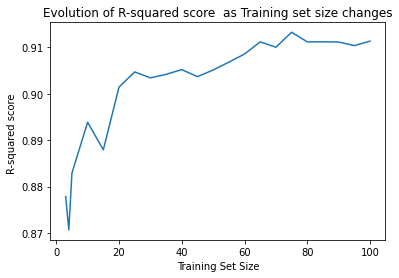

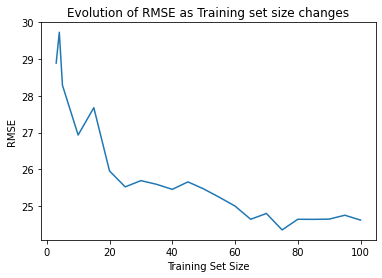

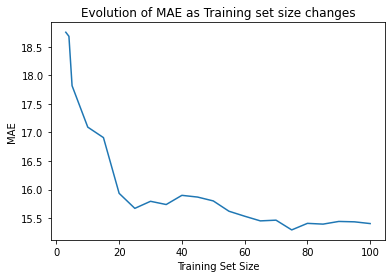

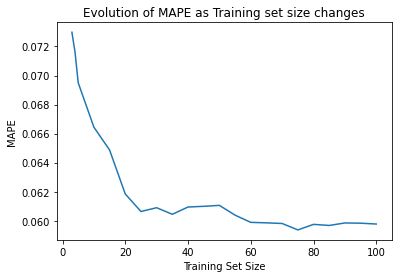

In [199]:
ylabel = ["R-squared score ","RMSE","MAE","MAPE"]
for i in range(4):
    plt.plot(np.concatenate((window_sizes, window_sizes2), axis=0),np.array(scores)[:,i])
    plt.xlabel("Training Set Size")
    plt.ylabel(ylabel[i])
    plt.title("Evolution of " + ylabel[i] +" as Training set size changes")
    plt.show()

In [188]:
print("Highest R-squared value is "+ str(np.max(np.array(scores)[:,0])))

Highest R-squared value is 0.9132723452700389


In [195]:
print("Metrics for the best model")
for i in range(len(scores[16])):
    print(ylabel[i] + ": " + str(scores[16][i]))

Metrics for the best model
R-squared score : 0.9132723452700389
RMSE: 24.348161777630995
MAE: 15.295832424331936
MAPE: 0.059367223853309455


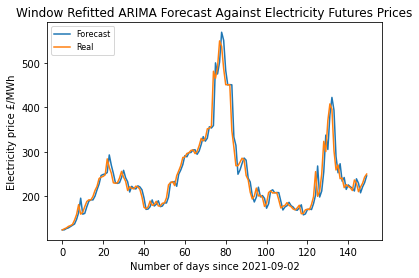

In [193]:
fc_series = pd.Series(forecasts[16][:,0])
plt.plot(fc_series, label='Forecast')
plt.plot(dfe['e_price'].values[-150:], label='Real')

plt.title('Window Refitted ARIMA Forecast Against Electricity Futures Prices')
plt.xlabel("Number of days since 2021-09-02")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

Find the R-squared score of the residuals

In [196]:
diff1 = forecasts[16][:,0] - dfe['e_price'].values[-151:-1]
diff2 = dfe['e_price'].values[-150:] - dfe['e_price'].values[-151:-1]
calc_metrics(diff1, real=diff2)

R-squared score is  -0.0154033816023742
RMSE is  24.348161777630995
MAE is  15.295832424331936
MAPE score is  595644497029531.5


(-0.0154033816023742,
 24.348161777630995,
 15.295832424331936,
 595644497029531.5)

In [15]:
def undiff(data, start_val):
    """
    :param data: numpy array to apply inverse of pandas diff function
    :param start_val: start value of the sequence
    :return: numpy array with undiff values
    """
    data[0] = start_val #first value of data array is NaN
    return np.cumsum(data)
#Test to see if undiff works
udf = undiff(dfe['e_price'].diff(),dfe['e_price'].iloc[0])
#if sum of differences is 0 then undiff works properly
print("Sum of differences between real and undiff values is ", np.sum(udf - dfe['e_price']))

Sum of differences between real and undiff values is  0.0


#### LSTM <a class="anchor" id="section_1_5"></a>
LSTM BaseLine model

Normalise data for neural network training

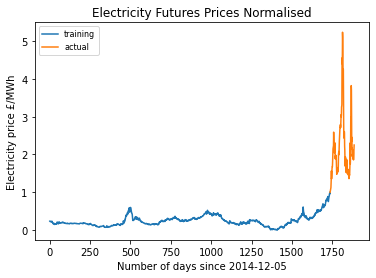

In [4]:
dat=dfe
train_max_val = np.max(dat['e_price'].iloc[:trainset_size])
train_min_val = np.min(dat['e_price'].iloc[:trainset_size])
max_min_diff = train_max_val - train_min_val
elecs_norm = pd.DataFrame(dat['e_price']).apply(lambda x:(x-train_min_val)/max_min_diff)
#plot
train = elecs_norm.values[:trainset_size]
test = elecs_norm.values[trainset_size:]
indices = np.arange(trainset_size,len(dat['e_price']),1)
test_series = pd.Series(test.ravel(), index = indices)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')

plt.title('Electricity Futures Prices Normalised')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [5]:
def make_single_lstm(units, observation_size, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(observation_size, 1)))
    model.add(tf.keras.layers.Dropout(dropout, noise_shape=None, seed=None))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
    return model

Perform grid search for best LSTM configuration

In [201]:
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)

In [19]:
#Fit the model, forecast and test the results
units = [64,128,256]
dropouts = np.arange(0,1,0.1)
models = []
histories = []
forecasts = []
results = []
for unit in units:
    unit_histories = []
    unit_models = []
    unit_forecasts = []
    unit_results = []
    for dropout in dropouts:
        print("unit ", unit, " dropout ", dropout)
        model = make_single_lstm(unit,10,dropout=dropout)
        unit_histories.append(model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]))
        forecast = model.predict(X_test)
        unit_forecasts.append(forecast)
        unit_models.append(model)
        unit_results.append(calc_metrics(forecast))
    models.append(unit_models)
    results.append(unit_results)
    histories.append(unit_histories)
    forecasts.append(unit_forecasts)
# model = make_single_lstm(64,10,dropout=0.2)
# model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
# forecast = model.predict(X_test)

unit  64  dropout  0.0
Epoch 1/15
1727/1727 [==============================] - 9s 4ms/step - loss: 9.0815e-04 - mape: 13257.6973 - mae: 0.0190 - val_loss: 0.3064 - val_mape: 15.0817 - val_mae: 0.3664
Epoch 2/15
1727/1727 [==============================] - 7s 4ms/step - loss: 0.0015 - mape: 14188.6357 - mae: 0.0242 - val_loss: 0.6521 - val_mape: 19.0234 - val_mae: 0.4610
Epoch 3/15
1727/1727 [==============================] - 7s 4ms/step - loss: 0.0020 - mape: 7827.7266 - mae: 0.0286 - val_loss: 0.3305 - val_mape: 16.9863 - val_mae: 0.4175
Epoch 4/15
1727/1727 [==============================] - 7s 4ms/step - loss: 0.0018 - mape: 17699.6270 - mae: 0.0259 - val_loss: 0.2845 - val_mape: 16.2341 - val_mae: 0.3938
R-squared score is  0.5811129913772686
MSE is  0.2844526747030072
MAPE score is  0.16234149096253206
unit  64  dropout  0.1
Epoch 1/15
1727/1727 [==============================] - 9s 4ms/step - loss: 0.0013 - mape: 13687.7461 - mae: 0.0245 - val_loss: 0.4756 - val_mape: 18.6878 - v

In [6]:
def denorm(data):
    """
    Function used to perform the denormalise the data
    :param data: normalised data, array like
    :return: denormalised data, array like
    """
    output = data * max_min_diff
    output = output + train_min_val
    return output

In [83]:
%store forecasts

Stored 'forecasts' (list)


In [203]:
%store -r forecasts
forecast_array = np.array(forecasts)
result_array = np.zeros((forecast_array.shape[0],forecast_array.shape[1],4))
for i in range(forecast_array.shape[0]):
    for j in range(forecast_array.shape[1]):
        result_array[i,j,:] = calc_metrics(denorm(forecast_array[i,j]), real=dfe['e_price'].values[trainset_size:])

R-squared score is  0.5811130290609672
RMSE is  53.51010505378564
MAE is  39.506695697021485
MAPE score is  0.14638221289226439
R-squared score is  0.36059271313463737
RMSE is  66.11137169752695
MAE is  51.74579388427733
MAPE score is  0.191243500518775
R-squared score is  0.24285272462679575
RMSE is  71.94118040297506
MAE is  58.45874412027994
MAPE score is  0.22202979193828185
R-squared score is  0.37769848862319877
RMSE is  65.22105286351729
MAE is  52.87422149047852
MAPE score is  0.2041199489950842
R-squared score is  -0.17241624988651538
RMSE is  89.52169408407093
MAE is  75.70532096354167
MAPE score is  0.29136602587650573
R-squared score is  0.7541376907269595
RMSE is  40.995232677021704
MAE is  29.36161938069661
MAPE score is  0.1097547354997666
R-squared score is  0.13123579386804718
RMSE is  77.06165593890695
MAE is  64.62747166137694
MAPE score is  0.25255717995056465
R-squared score is  0.44761090842311035
RMSE is  61.44830734334771
MAE is  49.27866563924154
MAPE score is 

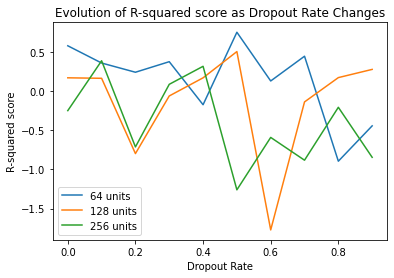

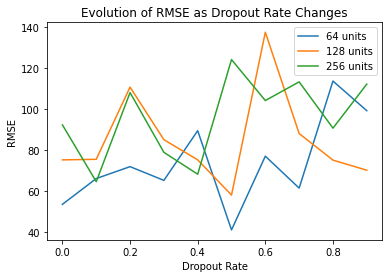

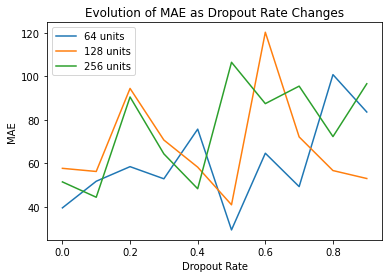

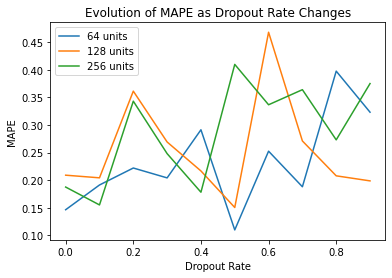

In [204]:
ylabels = ["R-squared score", "RMSE", "MAE", "MAPE"]
for i in range(4):
    for j in range(3):
        plt.plot(dropouts, result_array[j,:,i],label=str(units[j])+' units')
    plt.legend()
    plt.title("Evolution of "+ylabels[i]+" as Dropout Rate Changes")
    plt.xlabel("Dropout Rate")
    plt.ylabel(ylabels[i])
    plt.show()

In [63]:
print("Best model is LSTM with 64 units and dropout 0.5")
print("This model achieved the results")
for i in range(4):
    print(ylabels[i] + ": " + str(result_array[0,5,i]))

Best model is LSTM with 64 units and dropout 0.5
This model achieved the results
R-squared score: 0.7541376907269595
RMSE: 40.995232677021704
MAE: 29.36161938069661
MAPE: 0.1097547354997666


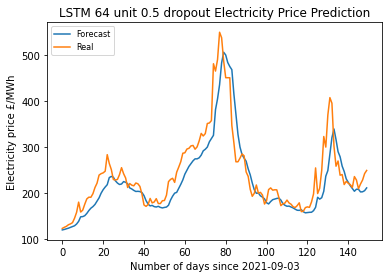

In [74]:
plt.plot(denorm(np.array(forecasts)[0,5,:]), label='Forecast')
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('LSTM 64 unit 0.5 dropout Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### CNN-LSTM <a class="anchor" id="section_1_6"></a>

CNN-LSTM

Deep CNN-LSTM-SeLU

In [ ]:
from keras.activations import selu
import convlstm
from importlib import reload
reload(convlstm) #reload import every time cell is run

window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
testset_size = 150
trainset_size = len(elecs_norm)-testset_size-window_size
X_train = dataset.take(trainset_size)
X_test = dataset.skip(trainset_size).take(testset_size)

cnnlstm_model = convlstm.cnnlstm_model(sequence_length=window_size,activation=selu)

cnnlstm_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)


150/150 [==============================] - 0s 2ms/step


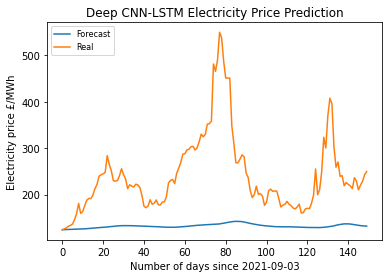

R-squared score is  -1.7181375186396104
RMSE is  136.30854752309682
MAE is  110.01587238159176
MAPE score is  0.4054335225230338


(-1.7181375186396104,
 136.30854752309682,
 110.01587238159176,
 0.4054335225230338)

In [246]:
cnnlstm_pred = cnnlstm_model.predict(X_test)
plt.plot(denorm(cnnlstm_pred), label='Forecast')
plt.plot(dfe['e_price'][trainset_size+window_size:].values, label='Real')
plt.title('Deep CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(cnnlstm_pred), real=dfe['e_price'][trainset_size+window_size:].values)

Unfortunately, this model was trained without a random seed. However retraining it with one results in the same conclusion: it is making useful forecasts.

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv1 (Conv1D)              (None, 8, 64)             256       
                                                                 
 conv2 (Conv1D)              (None, 6, 32)             6176      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 2, 16)             1040      
                                                                 
 conv4 (Conv1D)              (None, 1, 16)             528       
                                                           

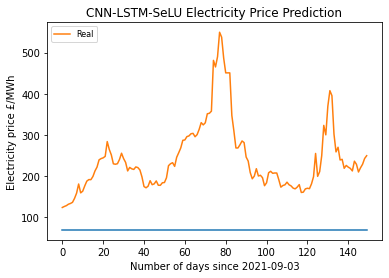

R-squared score is  -4.370266816052647
RMSE is  191.59550208267345
MAE is  172.83884431966143
MAPE score is  0.6861006046072117


(-4.370266816052647,
 191.59550208267345,
 172.83884431966143,
 0.6861006046072117)

In [31]:
tf.random.set_seed(1234)

window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.take(len(elecs_norm) - window_size - 150)
X_test = dataset.skip(len(elecs_norm) - window_size - 150).take(150)
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='selu'
filter_length=3
init = 'glorot_normal'
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv2')(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv3')(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv4')(x)
x = Convolution1D(filters=8, kernel_size=1, activation=None, padding='valid',
                  kernel_initializer=init,  name='conv5')(x)
x = LSTM(64, activation='relu',return_sequences=True)(x)
x = LSTM(64, activation='relu')(x)
x = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model.summary()
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)
pred = model.predict(X_test)
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][-150:].values, label='Real')
plt.title('CNN-LSTM-SeLU Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][-150:].values)

Trying out a Deep CNN-LSTM with ReLU and Batch Normalisation (These results do not appear in the report) however it was a trial to see if using batch normalisation would make any difference.

In [239]:
from keras.activations import selu
import convlstm_relu as convlstm
from importlib import reload
reload(convlstm) #reload import every time cell is run
tf.random.set_seed(1234)
checkpoint_path = "training_cnnlstm1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1727*5)

window_size=15
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
testset_size = 150
trainset_size = len(elecs_norm)-testset_size-window_size
X_train = dataset.take(trainset_size)
X_test = dataset.skip(trainset_size).take(testset_size)

cnnlstm_model = convlstm.cnnlstm_model(sequence_length=window_size,activation=selu)
cnnlstm_model.save_weights(checkpoint_path.format(epoch=0))

cnnlstm_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks=[cp_callback])


Model: "model_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 conv1 (Conv1D)              (None, 13, 64)            256       
                                                                 
 batch_normalization_72 (Bat  (None, 13, 64)           256       
 chNormalization)                                                
                                                                 
 conv2 (Conv1D)              (None, 11, 32)            6176      
                                                                 
 batch_normalization_73 (Bat  (None, 11, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_198 (MaxPooli  (None, 5, 32)            0 

150/150 [==============================] - 1s 2ms/step


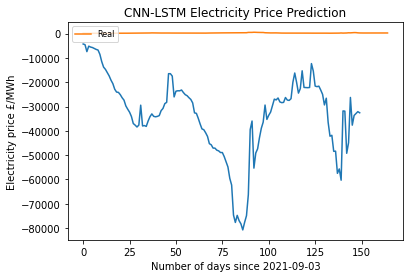

R-squared score is  -204244.16163418017
RMSE is  37364.85197815874
MAE is  33573.37447786458
MAPE score is  137.65238438326105


(-204244.16163418017, 37364.85197815874, 33573.37447786458, 137.65238438326105)

In [240]:
cnnlstm_pred = cnnlstm_model.predict(X_test)
plt.plot(denorm(cnnlstm_pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(cnnlstm_pred), real=dfe['e_price'][trainset_size+window_size:].values)

#### Shallow CNN-LSTM-SeLU <a class="anchor" id="section_1_3"></a>
We train the shallow CNN-LSTM-SeLU here

Model: "model_186"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv3 (Conv1D)              (None, 8, 16)             64        
                                                                 
 lstm_378 (LSTM)             (None, 64)                20736     
                                                                 
 tf.identity_177 (TFOpLambda  (None, 64)               0         
 )                                                               
                                                                 
 dense_380 (Dense)           (None, 1)                 65        
                                                                 
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_____________________________________________________

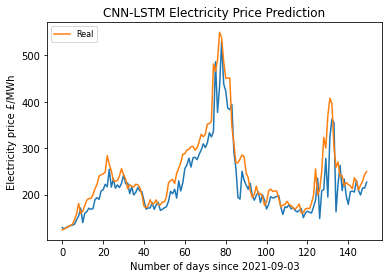

R-squared score is  0.7849870114695863
RMSE is  38.33714127595255
MAE is  26.642175087483725
MAPE score is  0.099710443925136


(0.7849870114695863, 38.33714127595255, 26.642175087483725, 0.099710443925136)

In [223]:
from keras.activations import selu
import convlstm2
from importlib import reload
reload(convlstm2) #reload import every time cell is run
checkpoint_path = "training_cnnlstm/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1727*5)



cnnlstm_model = convlstm2.cnnlstm_model(sequence_length=window_size,activation=selu)
cnnlstm_model.save_weights(checkpoint_path.format(epoch=0))

cnnlstm_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks=[cp_callback])#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
cnnlstm_pred = cnnlstm_model.predict(X_test)
plt.plot(denorm(cnnlstm_pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(cnnlstm_pred), real=dfe['e_price'][trainset_size:].values)

The result above was trained without the use of a random seed therefore its hard to replicate the result. A similar result was obtained after training for 24 epochs. Unfortunately, the weights were overwritten however the hierarchy of the results are similar enough to not cause a dispute in the results in the report.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv3 (Conv1D)              (None, 8, 16)             64        
                                                                 
 lstm_4 (LSTM)               (None, 64)                20736     
                                                                 
 tf.identity_4 (TFOpLambda)  (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/24
1727/1727 [==============================] -

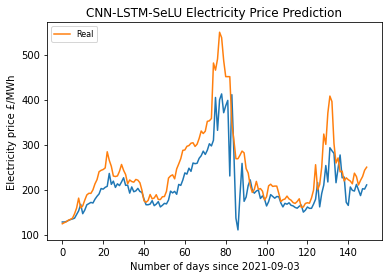

R-squared score is  0.5798760101067608
RMSE is  53.589057398937484
MAE is  37.81241086222331
MAPE score is  0.1360635071966364


(0.5798760101067608, 53.589057398937484, 37.81241086222331, 0.1360635071966364)

In [24]:
from keras.activations import selu
import convlstm2
from importlib import reload
tf.random.set_seed(1234)
reload(convlstm2) #reload import every time cell is run
checkpoint_path = "training_cnnlstm/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1,
#     save_weights_only=True,
#     save_freq=1727*5)

window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
testset_size = 150
trainset_size = len(elecs_norm)-testset_size-window_size
X_train = dataset.take(trainset_size)
X_test = dataset.skip(trainset_size).take(testset_size)

cnnlstm_model = convlstm2.cnnlstm_model(sequence_length=window_size,activation=selu)
cnnlstm_model.save_weights(checkpoint_path.format(epoch=0))

cnnlstm_model.fit(X_train,epochs=24,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
cnnlstm_pred = cnnlstm_model.predict(X_test)
plt.plot(denorm(cnnlstm_pred))
plt.plot(dfe['e_price'][-150:].values, label='Real')
plt.title('CNN-LSTM-SeLU Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(cnnlstm_pred), real=dfe['e_price'][-150:].values)

#### Shallow CNN-LSTM-ReLU <a class="anchor" id="section_1_3"></a>
Testing a shallow CNN-LSTM-ReLU

In [248]:
from keras.activations import selu
import convlstm_relu2 as convlstm
from importlib import reload
reload(convlstm) #reload import every time cell is run
tf.random.set_seed(1234)
checkpoint_path = "training_cnnlstm1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1727*5)

window_size=15
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
testset_size = 150
trainset_size = len(elecs_norm)-testset_size-window_size
X_train = dataset.take(trainset_size)
X_test = dataset.skip(trainset_size).take(testset_size)

cnnlstm_model = convlstm.cnnlstm_model(sequence_length=window_size,activation=selu)
cnnlstm_model.save_weights(checkpoint_path.format(epoch=0))

cnnlstm_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks=[cp_callback])#, callbacks =


Model: "model_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 conv4 (Conv1D)              (None, 13, 16)            64        
                                                                 
 batch_normalization_76 (Bat  (None, 13, 16)           64        
 chNormalization)                                                
                                                                 
 lstm1 (LSTM)                (None, 64)                20736     
                                                                 
 tf.identity_183 (TFOpLambda  (None, 64)               0         
 )                                                               
                                                                 
 dense_392 (Dense)           (None, 1)                 65

150/150 [==============================] - 1s 2ms/step


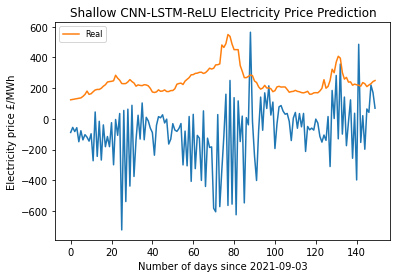

R-squared score is  -22.600886253535563
RMSE is  401.6534792886378
MAE is  336.1802335360209
MAPE score is  1.3891149254455695


(-22.600886253535563, 401.6534792886378, 336.1802335360209, 1.3891149254455695)

In [252]:
# cnnlstm_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks=[cp_callback])#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
cnnlstm_pred = cnnlstm_model.predict(X_test)
plt.plot(denorm(cnnlstm_pred))
plt.plot(dfe['e_price'][-150:].values, label='Real')
plt.title('Shallow CNN-LSTM-ReLU Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(cnnlstm_pred), real=dfe['e_price'][-150:].values)

#### Deep CNN-LSTM-ReLU stacked <a class="anchor" id="section_1_3"></a>
State of the art CNN-LSTM-ReLU stacked

In [ ]:

window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.take(len(elecs_norm) - window_size - 150)
X_test = dataset.skip(len(elecs_norm) - window_size - 150).take(150)
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='relu'
filter_length=3
init = 'glorot_normal'
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)

x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv2')(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv3')(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv4')(x)
x = Convolution1D(filters=8, kernel_size=1, activation=None, padding='valid',
                  kernel_initializer=init,  name='conv5')(x)
x = LSTM(64, activation='relu',return_sequences=True)(x)
x = LSTM(64, activation='relu')(x)
x = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred = model.predict(X_test)
plt.plot(pred)

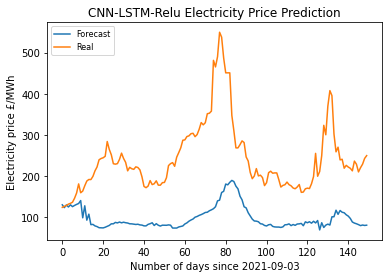

R-squared score is  -2.8419673513066934
RMSE is  162.05566317904393
MAE is  144.3429972005208
MAPE score is  0.5670555197620827


(-2.8419673513066934,
 162.05566317904393,
 144.3429972005208,
 0.5670555197620827)

In [31]:
plt.plot(denorm(pred), label='Forecast')
plt.plot(dfe['e_price'][-150:].values, label='Real')
plt.title('CNN-LSTM-Relu Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][-150:].values)

Unfortunately, the results for the model above were created without a tensorflow seed. However running it without the seed produces similar metric values and does not affect the conclusions in the report.

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv1 (Conv1D)              (None, 8, 64)             256       
                                                                 
 conv2 (Conv1D)              (None, 6, 32)             6176      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 2, 16)             1040      
                                                                 
 conv4 (Conv1D)              (None, 1, 16)             528       
                                                           

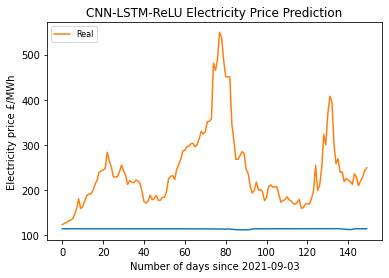

R-squared score is  -2.3912263914628453
RMSE is  152.25296859056093
MAE is  127.75389162190753
MAPE score is  0.4821502146917309


(-2.3912263914628453,
 152.25296859056093,
 127.75389162190753,
 0.4821502146917309)

In [30]:
tf.random.set_seed(1234)

window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.take(len(elecs_norm) - window_size - 150)
X_test = dataset.skip(len(elecs_norm) - window_size - 150).take(150)
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='relu'
filter_length=3
init = 'glorot_normal'
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv2')(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv3')(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv4')(x)
x = Convolution1D(filters=8, kernel_size=1, activation=None, padding='valid',
                  kernel_initializer=init,  name='conv5')(x)
x = LSTM(64, activation='relu',return_sequences=True)(x)
x = LSTM(64, activation='relu')(x)
x = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model.summary()
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)
pred = model.predict(X_test)
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][-150:].values, label='Real')
plt.title('CNN-LSTM-ReLU Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][-150:].values)

#### Parallel CNN-LSTM-ReLU <a class="anchor" id="section_1_3"></a>
Parallel CNN-LSTM-ReLU (quoted in paper)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm_30 (LSTM)                 (None, 64)           16896       ['input[0][0]']                  
                                                                                                  
 dropout_17 (Dropout)           (None, 64)           0           ['lstm_30[0][0]']                
                                                                                                  
 conv3 (Conv1D)                 (None, 8, 16)        64          ['input[0][0]']                  
                                                                                           

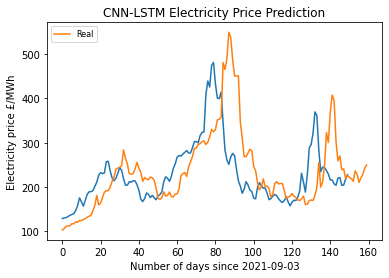

R-squared score is  0.8653617089768342
RMSE is  30.336933019854982
MAE is  20.064071520996094
MAPE score is  0.07285272815038056


(0.8653617089768342,
 30.336933019854982,
 20.064071520996094,
 0.07285272815038056)

In [37]:
tf.random.set_seed(1234)
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.take(len(elecs_norm) - window_size - 150)
X_test = dataset.skip(len(elecs_norm) - window_size - 150).take(150)
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='relu'
filter_length=3
init = 'glorot_normal'
batch_size=64
# ------ The layers in this block are not used. They are kept here to get the same results as the report
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                      kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv2')(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv3')(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv4')(x)
# ------ The layers in this block are not used. They are kept here to get the same results as the report
x = Convolution1D(filters=16, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = (tf.reshape(x, shape=(1,128)))
l = LSTM(64, activation='relu',return_sequences=True)(inputs)
l = Dropout(0.5)(l)
l = LSTM(64, activation='relu')(inputs)
l = Dropout(0.5)(l)
l = tf.reshape(l, shape=(1,64))
c = tf.reshape(concat([l,x],axis=1), shape=(1,192))
x = Dense(1)(c)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=64, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred = model.predict(X_test)
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][-150:].values)


In [18]:
model.save_weights("cnnlstm_relu/ck15.ckpt")

In [19]:
#model.load_weights("cnnlstm_relu/ck15.ckpt")

Deep Parallel CNN-LSTM-ReLU design based of the  state of the art model by Guo, we remake it into a parallel version

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 8, 64)        256         ['input[0][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, 6, 32)        6176        ['conv1[0][0]']                  
                                                                                                  
 alpha_dropout_45 (AlphaDropout  (None, 6, 32)       0           ['conv2[0][0]']                  
 )                                                                                          

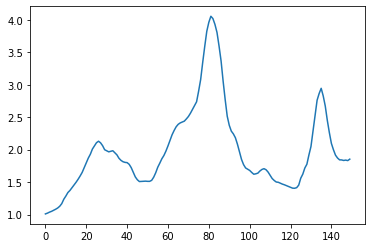

In [24]:
tf.random.set_seed(1234)
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.take(len(elecs_norm) - window_size - 150)
X_test = dataset.skip(len(elecs_norm) - window_size - 150).take(150)
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='relu'
filter_length=3
init = 'glorot_normal'
batch_size=64
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)
f = AlphaDropout(0.05)(x)

x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv2')(x)
x = AlphaDropout(0.05)(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv3')(x)
x = AlphaDropout(0.05)(x)
x = Convolution1D(filters=16, kernel_size=2, activation=activation, padding='valid',
                  kernel_initializer=init, name='conv4')(x)
x = AlphaDropout(0.05)(x)
x = Convolution1D(filters=16, kernel_size=1,activation=activation, padding='valid',
                  kernel_initializer=init, name='conv5')(x)
x = (tf.reshape(x, shape=(1,16)))
l = LSTM(64, activation='relu',return_sequences=True)(inputs)
l = Dropout(0.5)(l)
l = LSTM(64, activation='relu')(l)
l = Dropout(0.5)(l)
l = tf.reshape(l, shape=(1,64))
c = tf.reshape(concat([l,x],axis=1), shape=(1,80))
x = Dense(1)(c)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=64, verbose=1, shuffle=False)
pred = model.predict(X_test)
plt.plot(pred)

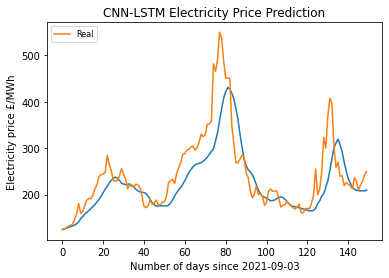

R-squared score is  0.6145635856944269
RMSE is  51.32911173013848
MAE is  34.330602239990235
MAPE score is  0.1218665426056653


(0.6145635856944269, 51.32911173013848, 34.330602239990235, 0.1218665426056653)

In [25]:
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][-150:].values)

#### Noisy Data <a class="anchor" id="section_1_3"></a>

Noisy data generation  - This is an early trial with the use of added Gausian noise to see whether this improves results by lowering overfitting.

In [28]:
def fn_addnoise(data,modify_length):
    # create 1D numpy data:
    npdata = data.values.copy().reshape(-1,1)
    # add uniform noise:
    npdata[:modify_length] = npdata[:modify_length] + np.random.uniform(size=modify_length).reshape(-1,1)
    # add laplace noise:
    #npdata[:modify_length] += np.random.laplace(loc=0.0, scale=1.0, size=modify_length).reshape(-1,1)
    return npdata

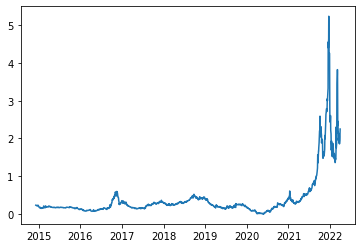

In [29]:
plt.plot(elecs_norm)

In [30]:
noisy_data = fn_addnoise(elecs_norm,trainset_size)

In [ ]:
window_size=40
noisy_data = fn_addnoise(elecs_norm,trainset_size)
dataset = keras.utils.timeseries_dataset_from_array(
        data=noisy_data,
        targets=noisy_data[40:],
        sequence_length=40,
        batch_size=1,
    )
model = make_single_lstm(256,40)
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size)
#X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
#Fit the model, forecast and test the results
hist = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
forecast = model.predict(X_test)

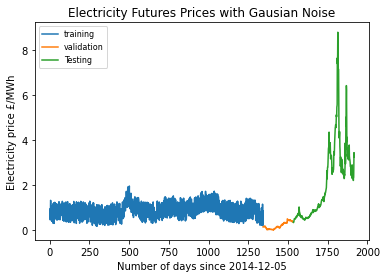

In [98]:
train = noisy_data[:trainset_size]
val = noisy_data[trainset_size:trainset_size]
test = noisy_data[trainset_size:]
indices = np.arange(trainset_size,len(dfe['e_price']),1)
val_indices = np.arange(trainset_size,trainset_size,1)
val_series = pd.Series(val.ravel(),index=val_indices)
test_series = pd.Series(test.ravel(), index = indices)
plt.plot(train, label='training')
plt.plot(val_series, label='validation')
plt.plot(test_series, label='Testing')

plt.title('Electricity Futures Prices with Gausian Noise')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

Training model with log prices

In [34]:
log_data = np.log(noisy_data+1)

In [36]:
window_size=40
valset_size = int(len(elecs_norm)*0.1)
noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
log_data = np.log(noisy_data+1)
dataset = keras.utils.timeseries_dataset_from_array(
        data=log_data,
        targets=log_data[40:],
        sequence_length=40,
        batch_size=1,
    )
model = make_single_lstm(256,40)
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-valset_size-window_size)
X_val =dataset.skip(trainset_size-valset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
#Fit the model, forecast and test the results
hist = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
forecast = np.exp(model.predict(X_test))-1

Epoch 1/15
344/344 [==============================] - 8s 19ms/step - loss: 0.0396 - mape: 44.0317 - mae: 0.1622 - val_loss: 0.0566 - val_mape: 17.9386 - val_mae: 0.1859
Epoch 2/15
344/344 [==============================] - 6s 18ms/step - loss: 0.0335 - mape: 43.7338 - mae: 0.1510 - val_loss: 0.1005 - val_mape: 23.2812 - val_mae: 0.2563
Epoch 3/15
344/344 [==============================] - 7s 20ms/step - loss: 0.0329 - mape: 43.9889 - mae: 0.1497 - val_loss: 0.1335 - val_mape: 26.4714 - val_mae: 0.2976
Epoch 4/15
344/344 [==============================] - 6s 17ms/step - loss: 0.0332 - mape: 44.5315 - mae: 0.1526 - val_loss: 0.1400 - val_mape: 27.2776 - val_mae: 0.3053
Epoch 5/15
344/344 [==============================] - 6s 17ms/step - loss: 0.0333 - mape: 44.5434 - mae: 0.1534 - val_loss: 0.1581 - val_mape: 28.8592 - val_mae: 0.3254
Epoch 6/15
344/344 [==============================] - 6s 17ms/step - loss: 0.0330 - mape: 44.7512 - mae: 0.1510 - val_loss: 0.1605 - val_mape: 29.2212 - va

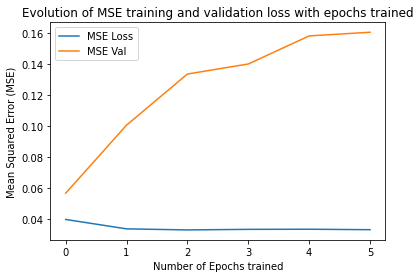

In [37]:
plt.plot(hist.history['loss'], label='MSE Loss')
plt.plot(hist.history['val_loss'], label='MSE Val')
plt.title("Evolution of MSE training and validation loss with epochs trained")
plt.xlabel("Number of Epochs trained")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()

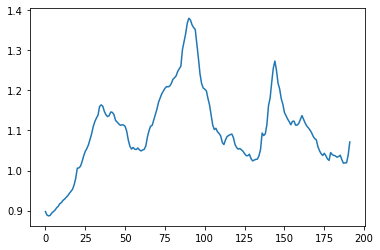

In [38]:
plt.plot(forecast)

In [40]:
calc_metrics(pd.Series(forecast.ravel()))

-31.930881396643954

#### AR-LSTM <a class="anchor" id="section_1_3"></a>
ARIMA based lstm

In [39]:
class weighted_layer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass

    def call(self, inputs):
        inp1, inp2 = inputs
        inp2 = tf.reshape(inp2,shape=(-1,1))
        return tf.reshape(tf.math.reduce_sum(tf.math.multiply(inp1,inp2)),shape=(-1,1))

AR -LSTM model with 20 AR terms

In [ ]:
div_data = elecs_norm[:-1]
print(div_data)

In [177]:
tf.random.set_seed(1234)

window_size=20

batches=1


dataset_ar = keras.utils.timeseries_dataset_from_array(
        data=div_data[:-1],
        targets=div_data[window_size:],
        sequence_length=window_size,
        batch_size=batches,
        shuffle=False
    )
testset_size = 150
trainset_size = len(elecs_norm) - window_size - testset_size
# --- Define training, validation and testing datasets
X_train = dataset_ar.take(trainset_size)
X_test = dataset_ar.skip(trainset_size).take(testset_size)

input1 = Input(shape=(window_size,1))
lstm1 = LSTM(64,activation='relu',return_sequences=False)(input1)
drop = Dropout(0.5)(lstm1)
dense1 = Dense(window_size)(drop)
w1 = weighted_layer()([input1,dense1])

ar_model = Model(inputs=input1,outputs=w1,name='ar_mod')
ar_model.compile(optimizer='adam',loss='mse')
ar_model.summary()
hist_ar = ar_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=32, verbose=1, shuffle=False)

ar_prediction = ar_model.predict(dataset_ar)[:,0]
print(ar_prediction.shape)
print(elecs_norm.values[window_size:].shape)

print(len(ar_prediction) == len(elecs_norm.values[window_size:]))
real_diff = elecs_norm.values[window_size:] - ar_prediction


Model: "ar_mod"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_201 (InputLayer)         [(None, 20, 1)]      0           []                               
                                                                                                  
 lstm_362 (LSTM)                (None, 64)           16896       ['input_201[0][0]']              
                                                                                                  
 dropout_191 (Dropout)          (None, 64)           0           ['lstm_362[0][0]']               
                                                                                                  
 dense_364 (Dense)              (None, 20)           1300        ['dropout_191[0][0]']            
                                                                                             

R-squared score is  0.5099409876039871
RMSE is  57.87774042353832
MAE is  43.43420901896159
MAPE score is  0.18545086728336127


(0.5099409876039871, 57.87774042353832, 43.43420901896159, 0.18545086728336127)

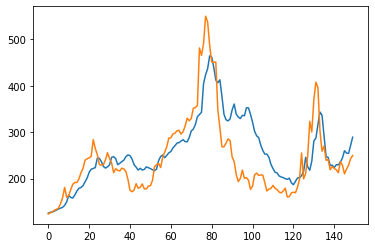

In [178]:
plt.plot(denorm(ar_prediction[-150:]))
plt.plot(dfe['e_price'].values[-150:])
calc_metrics(denorm(ar_prediction[-150:]))

Fitting it again does not make it much better

In [140]:
hist_ar = ar_model.fit(X_train,epochs=10,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False)

Epoch 1/10
1736/1736 [==============================] - 4s 2ms/step - loss: 1.6727e-04 - val_loss: 0.0570
Epoch 2/10
1736/1736 [==============================] - 4s 2ms/step - loss: 1.6729e-04 - val_loss: 0.0568
Epoch 3/10
1736/1736 [==============================] - 4s 2ms/step - loss: 1.6659e-04 - val_loss: 0.0576
Epoch 4/10
1736/1736 [==============================] - 4s 2ms/step - loss: 1.6678e-04 - val_loss: 0.0571
Epoch 5/10
1736/1736 [==============================] - 4s 2ms/step - loss: 1.6998e-04 - val_loss: 0.0569
Epoch 6/10
1736/1736 [==============================] - 4s 2ms/step - loss: 1.6743e-04 - val_loss: 0.0566
Epoch 7/10
1736/1736 [==============================] - 4s 3ms/step - loss: 1.6617e-04 - val_loss: 0.0568
Epoch 8/10
1736/1736 [==============================] - 5s 3ms/step - loss: 1.6657e-04 - val_loss: 0.0567
Epoch 9/10
1736/1736 [==============================] - 5s 3ms/step - loss: 1.6720e-04 - val_loss: 0.0568
Epoch 10/10
1736/1736 [=======================

#### AR-LSTM (from report) <a class="anchor" id="section_1_3"></a>
We now fit the AR model with only one historic value

Model: "ar_mod"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 lstm_32 (LSTM)                 (None, 64)           16896       ['input_2[0][0]']                
                                                                                                  
 dropout_19 (Dropout)           (None, 64)           0           ['lstm_32[0][0]']                
                                                                                                  
 dense_17 (Dense)               (None, 1)            65          ['dropout_19[0][0]']             
                                                                                             

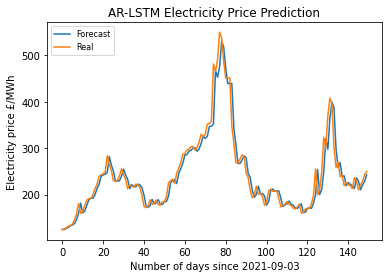

R-squared score is  0.9165095701787799
RMSE is  23.889426604011145
MAE is  14.674033241780599
MAPE score is  0.0565168921805805


(0.9165095701787799,
 23.889426604011145,
 14.674033241780599,
 0.0565168921805805)

In [40]:
tf.random.set_seed(1234)

window_size=1 # using only the previous value to forecast the next one

dataset_ar = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
        shuffle=False
    )
testset_size = 150
trainset_size = len(elecs_norm) - window_size - testset_size
# --- Define training, validation and testing datasets
X_train = dataset_ar.take(trainset_size)
X_test = dataset_ar.skip(trainset_size).take(testset_size)
#-- Define model
input1 = Input(shape=(window_size,1))
lstm1 = LSTM(64,activation='relu',return_sequences=False)(input1)
drop = Dropout(0.5)(lstm1)
dense1 = Dense(window_size)(drop)
# -- Add custom weighted input layer
w1 = weighted_layer()([input1,dense1])

ar_model = Model(inputs=input1,outputs=w1,name='ar_mod')
ar_model.compile(optimizer='adam',loss='mse', metrics=['mae','mape'])
ar_model.summary()
# -- train model
hist_ar = ar_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=32, verbose=1, shuffle=False)

ar_prediction = ar_model.predict(dataset_ar)[:,0] # make forecast
real_diff = elecs_norm.values[window_size:] - ar_prediction # find the difference between the AR forecast and real values
#Plot the AR forecast
plt.plot(denorm(ar_prediction)[-150:],label="Forecast")
plt.plot(dfe['e_price'].values[-150:], label='Real')
plt.title('AR-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(ar_prediction[-150:]))

Try MA model with it to make an ARMA model

In [41]:
tf.random.set_seed(1234)
window_size=2
real_diff = elecs_norm.values[1:].reshape(-1,1) - ar_prediction.reshape(-1,1)
print(real_diff.shape)
dataset = keras.utils.timeseries_dataset_from_array(
        data=real_diff[:-1],
        targets=real_diff[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
trainset_size = len(elecs_norm) - window_size - 150

X_train = dataset.take(trainset_size)
X_test = dataset.skip(trainset_size).take(150)
input2 = Input(shape=(window_size,1))
lstm2 = LSTM(128,activation='relu',return_sequences=False)(input2)
drop = Dropout(0.5)(lstm2)
dense2 = Dense(window_size)(drop)

w2 = weighted_layer()([input2,dense2])
ma_model = Model(inputs=input2,outputs=w2,name='ma_mod')
ma_model.compile(optimizer='adam',loss='mse')
ma_model.summary()
hist_ma = ma_model.fit(X_train,epochs=10,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)

(1886, 1)
Model: "ma_mod"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 1)]       0           []                               
                                                                                                  
 lstm_33 (LSTM)                 (None, 128)          66560       ['input_3[0][0]']                
                                                                                                  
 dropout_20 (Dropout)           (None, 128)          0           ['lstm_33[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 2)            258         ['dropout_20[0][0]']             
                                                                                   

The MA model makes the results worse

In [44]:
ma_terms = ma_model.predict(dataset)
ma_prediction = np.sum(ma_terms,axis=1)
print(ar_prediction.shape)
print(ma_prediction.shape)
arma_pred = ar_prediction[2:].reshape(-1,1)+ma_prediction.reshape(-1,1)
print(arma_pred.shape)
calc_metrics(denorm(arma_pred[-150:]))

1884/1884 [==============================] - 3s 1ms/step
(1886,)
(1884,)
(1884, 1)
R-squared score is  0.9102539522529716
RMSE is  24.76823408418092
MAE is  15.532617500813803
MAPE score is  0.058744427091472456


(0.9102539522529716,
 24.76823408418092,
 15.532617500813803,
 0.058744427091472456)

In [42]:
diff1 = (dfe['e_price'].values[-150:]-dfe['e_price'].values[-150-1:-1]).reshape(-1,1)
diff1.shape

(150, 1)

In [43]:
diff2 = denorm(ar_prediction[-150:]).reshape(-1,1)-dfe['e_price'].values[-150-1:-1].reshape(-1,1)
diff2.shape

(150, 1)

In [45]:
sklearn.metrics.r2_score(diff1,diff2)

0.022497898324748244

Trying out a CNN-LSTM with a weighted input layer as output is not as good

In [ ]:
import cnnlstm_arima
from importlib import reload
reload(cnnlstm_arima)

tf.random.set_seed(1234)

window_size=10

batches=1

dataset_ar = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=batches,
    )
testset_size = 150
trainset_size = len(elecs_norm) - window_size - testset_size
# --- Define training, validation and testing datasets
X_train = dataset_ar.take(trainset_size)
X_test = dataset_ar.skip(trainset_size).take(testset_size)

ar_model = cnnlstm_arima.cnnlstm_model()
ar_model.compile(optimizer='adam',loss='mse')
ar_model.summary()
hist_ar = ar_model.fit(X_train,epochs=10,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False)
ar_model_ckpt_path = "arma_model/ar_cnnlstm_weights_ckpt15.ckpt"
ar_model.save_weights(ar_model_ckpt_path)
ar_terms = ar_model.predict(dataset_ar)
ar_prediction = np.sum(ar_terms,axis=1)
print(ar_prediction.shape)
print(elecs_norm.values[window_size:].shape)

print(len(ar_prediction) == len(elecs_norm.values[window_size:]))
real_diff = elecs_norm.values[window_size:] - ar_prediction


R-squared score is  0.8043551936445746
RMSE is  36.56971192296743
MAE is  25.046415791829425
MAPE score is  0.08968433986206475


(0.8043551936445746,
 36.56971192296743,
 25.046415791829425,
 0.08968433986206475)

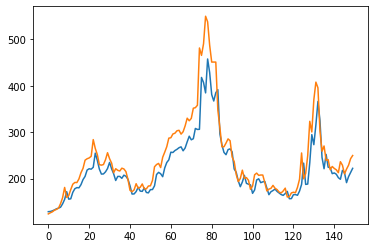

In [61]:
plt.plot(denorm(ar_prediction[-150:]))
plt.plot(dfe['e_price'].values[-150:])
calc_metrics(denorm(ar_prediction)[-150:])

The R2 score of the today's price tomorrow's forecast strategy

In [8]:
sklearn.metrics.r2_score(dfe['e_price'].values[-150:], dfe['e_price'].values[-151:-1])

0.9144857678381294

Wavelet LSTM

Using a Wavelet CNN-LSTM model. This was part of the prelim work and resulted in terrible results.

In [68]:


# Custom Activation function Layer
import tensorflow_wavelets.Layers.Threshold as Threshold
dataset = keras.utils.timeseries_dataset_from_array(
    data=elecs_norm['e_price'].iloc[:-1],
    targets=elecs_norm['e_price'].iloc[28:],
    sequence_length=28,
    batch_size=1,
)
import tensorflow_datasets as tfds
tfex = (tfds.as_numpy(
dataset))
#print(tfex.shape)
array = []
targets = []
for ex,tag in tfex:
      array.append(ex)
      targets.append(tag)
array = np.array(array)
targets = np.array(targets)
print(array.shape)
array = np.expand_dims(array,axis=-1)
targets= np.expand_dims(targets,axis=-1)
from tensorflow import keras

model = keras.Sequential()
model.add(keras.Input(shape=(1,28, 1)))
model.add(DWT.DWT(name="haar",concat=0))
model.add(ConvLSTM1D(
filters=128,
kernel_size=3,
#batch_input_shape=(None, 2, 28, 1),
#input_shape=(None,2, 28, 1),
padding="same",
return_sequences=True,
data_format="channels_last",
    activation="relu"
))
model.add(ConvLSTM1D(
filters=128,
kernel_size=3,
#batch_input_shape=(None, 2, 28, 1),
#input_shape=(None,2, 28, 1),
padding="same",
return_sequences=True,
data_format="channels_last",
    activation="relu"
))
model.add(ConvLSTM1D(
filters=128,
kernel_size=3,
#batch_input_shape=(None, 2, 28, 1),
#input_shape=(None,2, 28, 1),
padding="same",
return_sequences=True,
data_format="channels_last",
    activation="relu"
))
model.add(keras.layers.Flatten())
#model.add(LSTM(20))
model.add(keras.layers.Dense(1, activation="relu"))
model.summary()
model.compile(optimizer='adam',loss='mse')
#model.summary()
model.fit(array[:trainset_size],targets[:trainset_size], epochs=15)

(612, 1, 28)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaus (DWT)                  (None, 1, 14, 4)          0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 1, 14, 128)        203264    
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 14, 128)        393728    
                                                                 
 conv_lstm1d_2 (ConvLSTM1D)  (None, 1, 14, 128)        393728    
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 1793      
                                                                 
Total params: 992,513
Trainable params: 9

-2055.216991807978

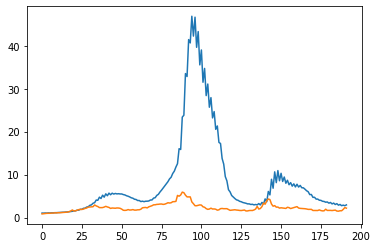

In [74]:
pred = (model.predict(array))
plt.plot(pred[trainset_size-28:])
plt.plot(elecs_norm[trainset_size:].values)
sklearn.metrics.r2_score(pd.Series(pred.ravel()[trainset_size-28:]),elecs_norm[trainset_size-1:])

In [35]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute, Lambda
from keras.layers import TimeDistributed
import tensorflow as tf
from keras import Input
from keras.layers import GRU

from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, UpSampling1D, UpSampling2D, ZeroPadding1D
# from keras.layers.advanced_activations import ParametricSoftplus, SReLU
from keras.callbacks import ModelCheckpoint, Callback
def ufcnn_model_concat(sequence_length=5000,
                       features=1,
                       nb_filter=150,
                       filter_length=5,
                       output_dim=1,
                       optimizer='adagrad',
                       loss='mse',
                       regression = True,
                       class_mode=None,
                       activation="relu",
                       init="lecun_uniform",
                       wavelet = False):
    #model = tf.keras.Sequential()

    #########################################################
    #x = ZeroPadding1D(2, name='input_padding') (inputs)# to avoid lookahead bias
    inputs = (keras.Input(shape=(1,sequence_length, features)))
    inputs = DWT.DWT(name="db6",concat=0)(inputs)
    inputs = tf.expand_dims(tf.reshape(inputs,shape=(-1,sequence_length*features)), axis=-1)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='valid', kernel_initializer=init, input_shape=(1,sequence_length, features),name='conv1')(inputs)
    start = Activation(activation, name='relu1')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv2')(start)
    start2 = Activation(activation, name='relu2')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv3')(start2)
    x = Activation(activation, name='relu3')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv4')(x)
    x = Activation(activation, name='relu4')(x)
    #########################################################
    x = tf.keras.layers.concatenate([start2, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv5')(x)
    x = Activation(activation, name='relu5')(x)
    #########################################################

    #########################################################
    x = tf.keras.layers.concatenate([start, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv6')(x)
    x = Activation(activation, name='relu6')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv7')(x)
    #x = Convolution1D(filters=1, kernel_size=1, padding='same', kernel_initializer=init, name='conv8')(x)

    x = Activation('relu', name='relu7')(x)

    y = LSTM(64)(x)
    # y = Dense(1)(y)
    x = tf.keras.layers.concatenate([x, y], axis=-1)
    x = Dense(1)(x)
    ufcnn_wavelet_model = tf.keras.Model(inputs=inputs, outputs=x)
    ufcnn_wavelet_model.compile(optimizer=optimizer, loss='mse')

    return ufcnn_wavelet_model

In [66]:
window_size=10
#noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
log_data = np.log(elecs_norm+1)
batches=64
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)

# --- Define training, validation and testing datasets


model = ufcnn_model_concat(10,1)
hist_wa = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/15
1727/1727 [==============================] - 28s 12ms/step - loss: 6.7934e-04 - val_loss: 0.6589
Epoch 2/15
1727/1727 [==============================] - 20s 11ms/step - loss: 6.1126e-04 - val_loss: 0.6307
Epoch 3/15
1727/1727 [==============================] - 20s 12ms/step - loss: 5.5387e-04 - val_loss: 0.6170
Epoch 4/15
1727/1727 [==============================] - 20s 12ms/step - loss: 5.2540e-04 - val_loss: 0.6090
Epoch 5/15
1727/1727 [==============================] - 20s 12ms/step - loss: 5.0731e-04 - val_loss: 0.6055
Epoch 6/15
1727/1727 [==============================] - 20s 12ms/step - loss: 4.9012e-04 - val_loss: 0.6025
Epoch 7/15
1727/1727 [==============================] - 20s 12ms/step - loss: 4.7742e-04 - val_loss: 0.6001
Epoch 8/15
1727/1727 [==============================] - 20s 12ms/step - loss: 4.6692e-04 - val_loss: 0.5965
Epoch 9/15
1727/1727 [==============================] - 20s 12ms/step - loss: 4.5356e-04 - val_loss: 0.5869
Epoch 10/15
1727/1727 [=====

150/150 [==============================] - 1s 3ms/step
R-squared score is  -8.217968968052714
RMSE is  251.01807707828436
MAE is  237.53434028593702
MAPE score is  0.980386603381653


(-8.217968968052714, 251.01807707828436, 237.53434028593702, 0.980386603381653)

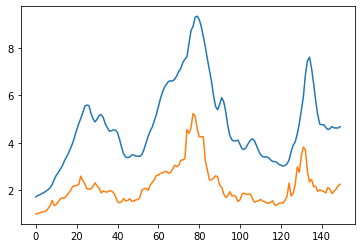

In [68]:
model.save_weights('./ufcnn_lstm_checkpoints/epoch15')

f = np.exp(model.predict(X_test.take(testset_size)))-1

plt.plot(f)
plt.plot(elecs_norm[trainset_size:].values)
calc_metrics(pd.Series(f.ravel()))

In [34]:
from ufcnn import ufcnn_model
model = ufcnn_model(10,1)

-7.715862015302239

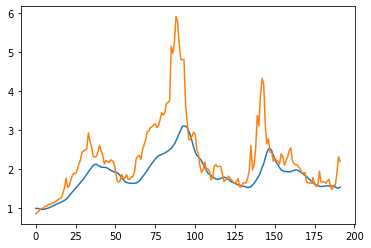

In [48]:
f = np.exp(model.predict(X_test.take(testset_size)))-1
plt.plot(f)
plt.plot(elecs_norm[trainset_size:].values)
sklearn.metrics.r2_score(pd.Series(f.ravel()).values - elecs_norm[-151:-1].values,elecs_norm[trainset_size-1:].values - elecs_norm[-151:-1].values)

so do a loop like refitting arima and take from dataset an adequate amount of data to fit model for 1 day ahead.

In [21]:
window_size=5
price_change = elecs_norm.diff(1).dropna() > 0
price_change['e_price'] = price_change['e_price'].astype(int)

dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=price_change[window_size:],
        sequence_length=window_size,
        batch_size=1,
)
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
hist = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/15
443/443 [==============================] - 5s 5ms/step - loss: 18.1576 - accuracy: 0.5350 - precision: 0.5156 - recall: 0.4670 - val_loss: 0.6747 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 2/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6974 - accuracy: 0.5192 - precision: 0.4963 - recall: 0.3160 - val_loss: 0.6746 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 3/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.5214 - precision: 0.5000 - recall: 0.3160 - val_loss: 0.6746 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 4/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.5214 - precision: 0.5000 - recall: 0.3160 - val_loss: 0.6746 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 5/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.5214 - p

In [125]:
from ufcnn import ufcnn_model
model = ufcnn_model(10,1)
hist = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])


Epoch 1/15
1727/1727 [==============================] - 6s 3ms/step - loss: 8.4204e-04 - val_loss: 1.3200
Epoch 2/15
1727/1727 [==============================] - 4s 2ms/step - loss: 0.0022 - val_loss: 1.7170
Epoch 3/15
1727/1727 [==============================] - 4s 2ms/step - loss: 0.0029 - val_loss: 1.3255
Epoch 4/15
1727/1727 [==============================] - 4s 2ms/step - loss: 0.0031 - val_loss: 1.3385
Epoch 5/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0.0045 - val_loss: 3.1727
Epoch 6/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0.0038 - val_loss: 2.2068
Epoch 7/15
1727/1727 [==============================] - 4s 3ms/step - loss: 0.0040 - val_loss: 2.4600
Epoch 8/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0.0046 - val_loss: 2.2782
Epoch 9/15
1727/1727 [==============================] - 4s 3ms/step - loss: 0.0051 - val_loss: 2.3315
Epoch 10/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0

Transfer learning

In [13]:
window_size=10
offset=11
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size = 1
)
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)

In [ ]:
m  = keras.Sequential()
m.add(LSTM(64, activation='relu', input_shape=(10, 1),return_sequences=True,name='tran_lstm'))
m.add(tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None))
m.add(LSTM(64, activation='relu',return_sequences=False,name='lstm2'))
m.add(tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
m.summary()
m.compile(optimizer='adam', loss='mse', metrics=['mae','mape'], run_eagerly=True)
m.fit(X_train,epochs=15,validation_data=X_test, verbose=1, shuffle=False)
t_pred = m.predict(X_test)
calc_metrics(denorm(t_pred),real =dfe['e_price'].values[trainset_size:])
m.trainable=False

In [65]:
ma = make_single_lstm(64,10, 0.5)
ma.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_162 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


This is a preview of the application of transfer learning

In [ ]:
tran_preds = []
train_num=50

aux_model = tf.keras.Model(inputs=m.inputs,
                           outputs= m.layers[0].output)
aux_model.trainable=False
input = Input(window_size,1)
x = aux_model(input)
x = LSTM(64,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = Dense(1)
# for i in range(testset_size):
#     train = dataset.skip(trainset_size-window_size-train_num+i).take(train_num)
#     test = dataset.skip(trainset_size-window_size+i).take(1)
#     inputs = tf.keras.Input(shape=(window_size, 1))
#     x = aux_model(inputs)
#     #x = tf.keras.layers.Dropout(0.2)(x)
#     outputs = tf.keras.layers.Dense(1)(x)
#     tran_model = tf.keras.Model(inputs, outputs)
#     tran_model.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
#     tran_model.fit(train,epochs=2,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)
#     tran_preds.append(tran_model.predict(test))

In [52]:
len(tran_preds)

140

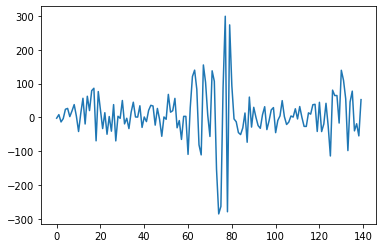

In [53]:
plt.plot(np.array(tran_preds).ravel())

CNN

In [25]:
from keras.layers.convolutional import Convolution1D, MaxPooling1D
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size = 1
)
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
cnn_model = Sequential([
    Input(shape=(10,1)),
    Convolution1D(64,3,activation='relu', input_shape=(10,1)),
    BatchNormalization(),
    Convolution1D(128,3, activation='relu'),
    BatchNormalization(),
    Convolution1D(256,3),
    MaxPooling1D(2,strides=2)
])
cnn_model.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
cnn_model.summary()
cnn_model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 8, 64)             256       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 64)            256       
 hNormalization)                                                 
                                                                 
 conv1d_28 (Conv1D)          (None, 6, 128)            24704     
                                                                 
 batch_normalization_5 (Batc  (None, 6, 128)           512       
 hNormalization)                                                 
                                                                 
 conv1d_29 (Conv1D)          (None, 4, 256)            98560     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 2, 256)         

In [55]:
calc_metrics(dfe['e_price'].values[-151:-1]-dfe['e_price'].values[-151:-1],dfe['e_price'].values[-150:]-dfe['e_price'].values[-151:-1])

R-squared score is  -0.0011966861395704687
RMSE is  24.17723198934623
MAE is  14.780533333333333
MAPE score is  0.98


(-0.0011966861395704687, 24.17723198934623, 14.780533333333333, 0.98)

#### UFCNN-LSTM <a class="anchor" id="section_1_20"></a>

This is the test for the UFCNN-LSTM. It seems that the -3000 result was not recreated with the random seed however the result is still terrible and worse than the deep CNN-LSTM

In [64]:
tf.random.set_seed(1234)
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm.iloc[:-1],
        targets=elecs_norm.iloc[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.take(len(elecs_norm) - window_size-150)
X_test = dataset.skip(len(elecs_norm) - window_size-150).take(150)
import ufcnn
reload(ufcnn)
model = ufcnn.ufcnn_model(10,1)
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
u2_pred = model.predict(X_test)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 9, 50)        150         ['input[0][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, 9, 50)        5050        ['conv1[0][0]']                  
                                                                                                  
 conv3 (Conv1D)                 (None, 9, 50)        5050        ['conv2[0][0]']                  
                                                                                           

R-squared score is  -8.45151277288498
RMSE is  254.17804806684669
MAE is  240.53125072765354
MAPE score is  0.99261433327644


(-8.45151277288498, 254.17804806684669, 240.53125072765354, 0.99261433327644)

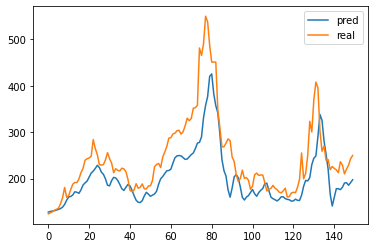

In [65]:
plt.plot(denorm(u2_pred),label = "pred")
plt.plot(dfe['e_price'][-150:].values, label = "real")
plt.legend()
calc_metrics(u2_pred)